In [2]:
!pip install segmentation-models-pytorch --quiet


In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ISIC Dataset
class ISICDataset(Dataset):
    def __init__(self, img_folder, mask_folder, img_filenames, mask_filenames, transform=None, target_size=(256, 256)):
        # Filter out non-image files (e.g., .txt files)
        self.img_filenames = [f for f in sorted(img_filenames) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.mask_filenames = [f for f in sorted(mask_filenames) if f.endswith('.png')]

        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_filenames[idx])

        # Lo image and mask using PIL
        
        image = Image.open(img_path).convert("RGB")  # Convert to RGB for consistency
        mask = Image.open(mask_path).convert("L")   # Convert to grayscale for masks

        # Resize image and mask
        if self.target_size:
            image = image.resize(self.target_size, Image.Resampling.LANCZOS)
            mask = mask.resize(self.target_size, Image.Resampling.NEAREST)

        # Convert to numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Normalize image and mask
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) / 255.0  # HWC to CHW and normalize
        mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]

        return torch.tensor(image), torch.tensor(mask)

# Paths
train_img_folder_path = "/kaggle/input/isic-2018/data/images/train"
train_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/train"
val_img_folder_path = "/kaggle/input/isic-2018/data/images/val"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/val"

# Get filenames of images and masks
train_img_filenames = os.listdir(train_img_folder_path)
train_mask_filenames = os.listdir(train_mask_folder_path)

val_img_filenames = os.listdir(val_img_folder_path)
val_mask_filenames = os.listdir(val_mask_folder_path)

# Ensure the filenames are sorted to match correctly
train_img_filenames.sort()
train_mask_filenames.sort()

val_img_filenames.sort()
val_mask_filenames.sort()

# Datasets and DataLoaders
train_dataset = ISICDataset(
    img_folder=train_img_folder_path, 
    mask_folder=train_mask_folder_path, 
    img_filenames=train_img_filenames, 
    mask_filenames=train_mask_filenames
)

val_dataset = ISICDataset(
    img_folder=val_img_folder_path, 
    mask_folder=val_mask_folder_path, 
    img_filenames=val_img_filenames, 
    mask_filenames=val_mask_filenames
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    if target.ndim == 3:  # Add channel dimension if missing
        target = target.unsqueeze(1)
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return 1 - dice.mean()

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss improved. Saving model...")
        torch.save(model.state_dict(), self.path)

# Model: Teacher (UNet++ with ResNet34 Encoder)
teacher_model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# Optimizer for Teacher Model
teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=1e-4)

# Model: Student (DeepLabV3 with MobileNetV3 Encoder)
student_model = smp.DeepLabV3(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# Optimizer for Student Model
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)

# Knowledge Distillation Loss
def knowledge_distillation_loss(teacher_pred, student_pred, target, alpha=0.5, temperature=4):
    """
    Combines teacher's soft predictions with ground truth (hard labels).
    teacher_pred: Teacher's predictions
    student_pred: Student's predictions
    target: Ground truth labels
    alpha: Weight for balancing soft and hard losses
    temperature: Controls the softening of teacher predictions
    """
    # Soft labels (distilled knowledge from teacher)
    teacher_soft = torch.sigmoid(teacher_pred / temperature)
    student_soft = torch.sigmoid(student_pred / temperature)
    soft_loss = torch.nn.functional.binary_cross_entropy(student_soft, teacher_soft)

    # Hard labels (ground truth)
    hard_loss = dice_loss(student_pred, target)

    # Combine losses
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Training Teacher Model
def train_teacher(epochs=10, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_teacher_model.pth')
    for epoch in range(epochs):
        teacher_model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            teacher_optimizer.zero_grad()
            outputs = teacher_model(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            teacher_optimizer.step()
            epoch_loss += loss.item()

        # Validate the model
        teacher_model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = teacher_model(images)
                val_loss += dice_loss(outputs, masks).item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss, teacher_model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Loading best model...")
            teacher_model.load_state_dict(torch.load('best_teacher_model.pth'))
            break

# Training Student Model using Teacher's Predictions
def train_student(epochs=10, alpha=0.5, temperature=4):
    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()  # Teacher is frozen during student training

        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)

            # Teacher's output (soft labels)
            with torch.no_grad():
                teacher_pred = teacher_model(images)

            # Student's output
            student_pred = student_model(images)

            # Compute loss
            loss = knowledge_distillation_loss(teacher_pred, student_pred, masks, alpha, temperature)

            # Backpropagation
            student_optimizer.zero_grad()
            loss.backward()
            student_optimizer.step()

            epoch_loss += loss.item()

        # Validation Step
        student_model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                teacher_pred = teacher_model(images)
                student_pred = student_model(images)
                val_loss += knowledge_distillation_loss(teacher_pred, student_pred, masks, alpha, temperature).item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

# Train Teacher Model
train_teacher(epochs=10, patience=5)

# Train Student Model
train_student(epochs=10, alpha=0.5, temperature=4)


Using device: cuda


100%|██████████| 163/163 [12:22<00:00,  4.56s/it]


Epoch 1, Train Loss: 0.4420, Val Loss: 0.2881
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:25<00:00,  4.57s/it]


Epoch 2, Train Loss: 0.3094, Val Loss: 0.2366
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:26<00:00,  4.58s/it]


Epoch 3, Train Loss: 0.2219, Val Loss: 0.1917
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:29<00:00,  4.60s/it]


Epoch 4, Train Loss: 0.1636, Val Loss: 0.1649
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:27<00:00,  4.59s/it]


Epoch 5, Train Loss: 0.1352, Val Loss: 0.1377
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:24<00:00,  4.57s/it]


Epoch 6, Train Loss: 0.1193, Val Loss: 0.1383
EarlyStopping counter: 1 out of 5


100%|██████████| 163/163 [12:22<00:00,  4.56s/it]


Epoch 7, Train Loss: 0.1006, Val Loss: 0.1189
Validation loss improved. Saving model...


100%|██████████| 163/163 [12:26<00:00,  4.58s/it]


Epoch 8, Train Loss: 0.0929, Val Loss: 0.1222
EarlyStopping counter: 1 out of 5


100%|██████████| 163/163 [12:27<00:00,  4.59s/it]


Epoch 9, Train Loss: 0.0871, Val Loss: 0.1276
EarlyStopping counter: 2 out of 5


100%|██████████| 163/163 [12:27<00:00,  4.59s/it]


Epoch 10, Train Loss: 0.0792, Val Loss: 0.1229
EarlyStopping counter: 3 out of 5


100%|██████████| 163/163 [13:09<00:00,  4.84s/it]


Epoch 1, Train Loss: 0.4499, Val Loss: 0.3915


100%|██████████| 163/163 [13:10<00:00,  4.85s/it]


Epoch 2, Train Loss: 0.3527, Val Loss: 0.3546


100%|██████████| 163/163 [13:10<00:00,  4.85s/it]


Epoch 3, Train Loss: 0.3103, Val Loss: 0.3207


100%|██████████| 163/163 [13:11<00:00,  4.86s/it]


Epoch 4, Train Loss: 0.2879, Val Loss: 0.3000


100%|██████████| 163/163 [13:07<00:00,  4.83s/it]


Epoch 5, Train Loss: 0.2779, Val Loss: 0.3033


100%|██████████| 163/163 [13:06<00:00,  4.83s/it]


Epoch 6, Train Loss: 0.2711, Val Loss: 0.2932


100%|██████████| 163/163 [13:07<00:00,  4.83s/it]


Epoch 7, Train Loss: 0.2643, Val Loss: 0.2872


100%|██████████| 163/163 [13:07<00:00,  4.83s/it]


Epoch 8, Train Loss: 0.2612, Val Loss: 0.2864


100%|██████████| 163/163 [13:14<00:00,  4.87s/it]


Epoch 9, Train Loss: 0.2579, Val Loss: 0.2975


100%|██████████| 163/163 [13:12<00:00,  4.86s/it]


Epoch 10, Train Loss: 0.2560, Val Loss: 0.2930


In [18]:
def dice_coefficient(pred, target, smooth=1e-6):
    # Ensure both pred and target have the same number of dimensions
    if pred.ndim != target.ndim:
        target = target.unsqueeze(1)  # Add channel dimension to target if missing

    pred = (torch.sigmoid(pred) > 0.5).float()  # Threshold predictions
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean().item()


In [19]:
def validate_and_save_predictions(model, data_loader, save_path="predictions"):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    dice_scores = []
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(data_loader)):
            images, masks = images.to(device), masks.to(device)

            # Debugging: Print shapes
            print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")

            # Get predictions
            outputs = model(images)

            # Debugging: Print output shape
            print(f"Outputs shape: {outputs.shape}")

            # Ensure target dimensions match output
            if masks.ndim != outputs.ndim:
                masks = masks.unsqueeze(1)

            dice_score = dice_coefficient(outputs, masks)
            dice_scores.append(dice_score)

            # Save predicted masks as images
            preds = torch.sigmoid(outputs) > 0.5  # Threshold to binary mask
            preds = preds.cpu().numpy()

            for i in range(preds.shape[0]):
                pred_mask = (preds[i, 0] * 255).astype(np.uint8)  # Rescale to 0-255
                pred_image = Image.fromarray(pred_mask)
                pred_image.save(os.path.join(save_path, f"prediction_{idx * data_loader.batch_size + i}.png"))

    avg_dice = np.mean(dice_scores)
    print(f"Validation Dice Coefficient: {avg_dice:.4f}")


In [20]:
# Validate Teacher Model and Save Predictions
print("Validating Teacher Model...")
validate_and_save_predictions(teacher_model, val_loader, save_path="teacher_predictions")

# Validate Student Model and Save Predictions
print("Validating Student Model...")
validate_and_save_predictions(student_model, val_loader, save_path="student_predictions")

Validating Teacher Model...


 14%|█▍        | 1/7 [00:07<00:46,  7.82s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 29%|██▊       | 2/7 [00:09<00:21,  4.40s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 43%|████▎     | 3/7 [00:10<00:10,  2.61s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 57%|█████▋    | 4/7 [00:12<00:07,  2.34s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 71%|███████▏  | 5/7 [00:14<00:04,  2.36s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 86%|████████▌ | 6/7 [00:17<00:02,  2.38s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Images shape: torch.Size([4, 3, 256, 256]), Masks shape: torch.Size([4, 256, 256])
Outputs shape: torch.Size([4, 1, 256, 256])
Validation Dice Coefficient: 0.8816
Validating Student Model...


  0%|          | 0/7 [00:00<?, ?it/s]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 14%|█▍        | 1/7 [00:07<00:47,  7.92s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 29%|██▊       | 2/7 [00:10<00:22,  4.53s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 43%|████▎     | 3/7 [00:10<00:10,  2.69s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 57%|█████▋    | 4/7 [00:12<00:07,  2.39s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


 71%|███████▏  | 5/7 [00:14<00:04,  2.39s/it]

Images shape: torch.Size([16, 3, 256, 256]), Masks shape: torch.Size([16, 256, 256])
Outputs shape: torch.Size([16, 1, 256, 256])


100%|██████████| 7/7 [00:17<00:00,  2.56s/it]

Images shape: torch.Size([4, 3, 256, 256]), Masks shape: torch.Size([4, 256, 256])
Outputs shape: torch.Size([4, 1, 256, 256])
Validation Dice Coefficient: 0.8714


In [24]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm

# Save and Display Predicted Masks
def save_predictions(model, data_loader, save_path="predictions", num_samples=5):
    model.eval()
    os.makedirs(save_path, exist_ok=True)
    samples_saved = 0

    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(data_loader)):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()

            # Loop through the batch and save images
            for i in range(preds.shape[0]):
                if samples_saved >= num_samples:
                    return
                pred_mask = (preds[i, 0] * 255).astype(np.uint8)
                pred_image = Image.fromarray(pred_mask)
                pred_image.save(f"{save_path}/pred_{samples_saved}.png")
                samples_saved += 1


In [25]:
def plot_training_metrics(train_losses, val_losses, train_dice, val_dice):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.savefig("loss_plot.png")
    plt.show()

    # Plot Dice Coefficient
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_dice, label="Train Dice Coefficient", marker="o")
    plt.plot(epochs, val_dice, label="Validation Dice Coefficient", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.title("Training and Validation Dice Coefficient")
    plt.legend()
    plt.grid()
    plt.savefig("dice_plot.png")
    plt.show()


In [27]:
def display_predictions(model, data_loader, num_samples=5):
    """
    Display predicted masks alongside the original images and ground truth.
    """
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                # Convert tensors to numpy for visualization
                image = (images[i].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
                mask = (masks[i].cpu().numpy() * 255).astype(np.uint8)
                pred_mask = (preds[i, 0] * 255).astype(np.uint8)

                # Plot original image, ground truth, and predicted mask
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()
                samples_shown += 1


Teacher Model Predictions:


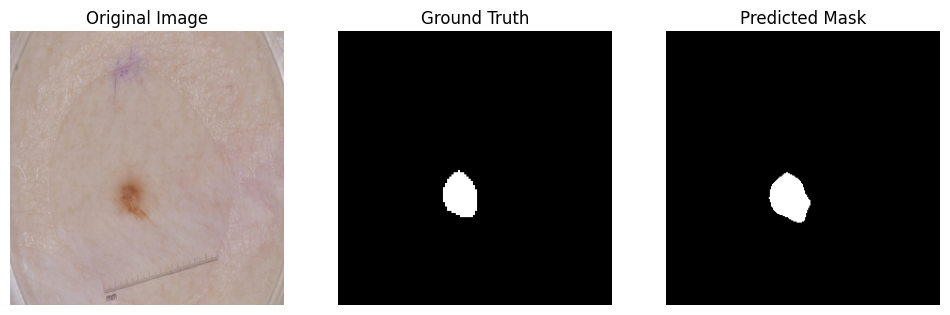

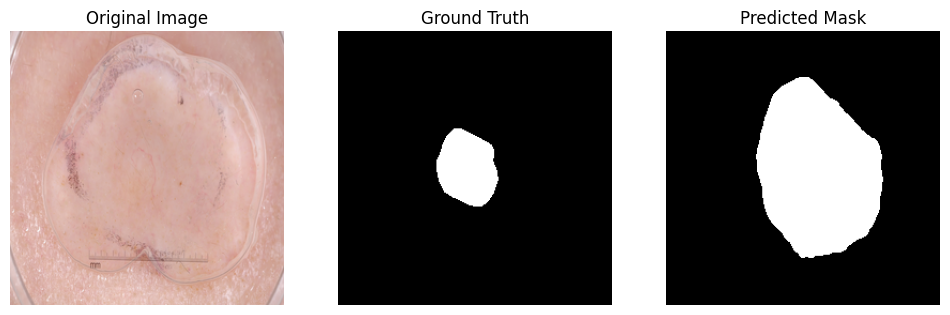

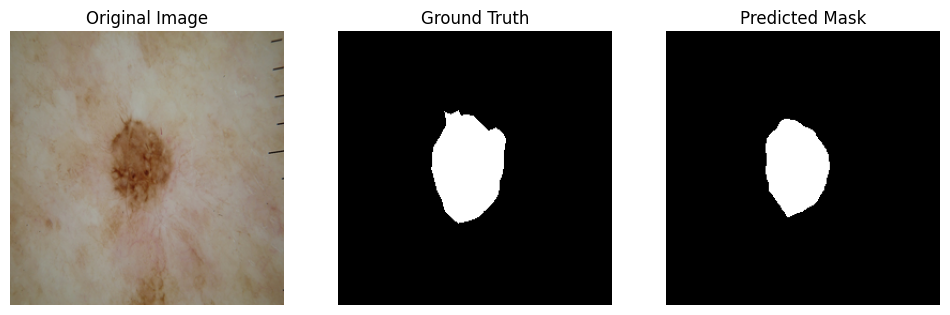

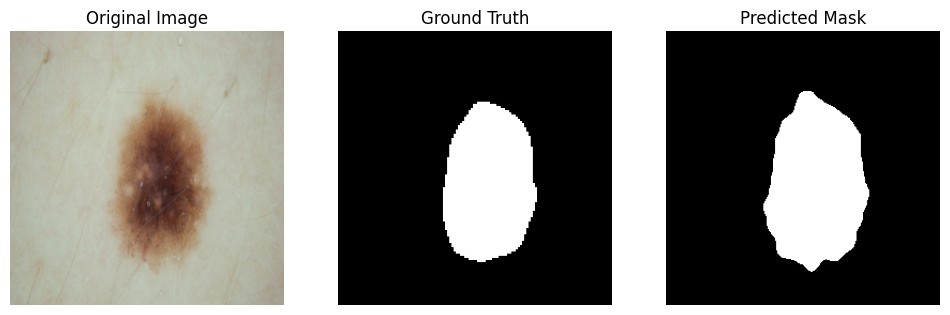

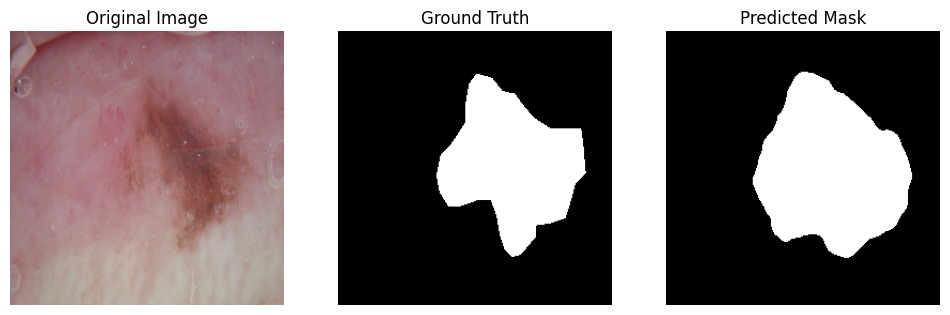

Student Model Predictions:


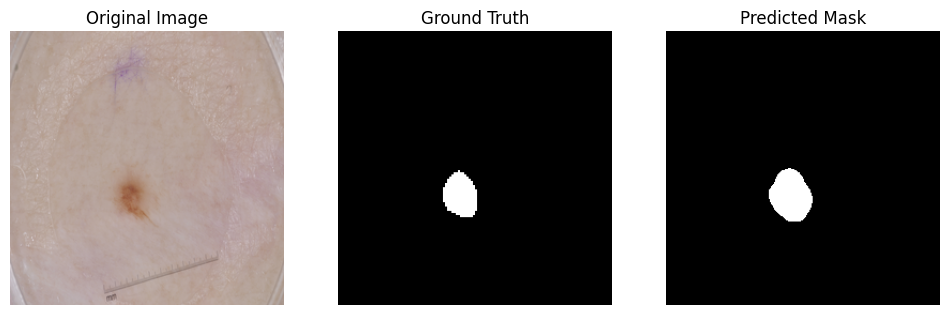

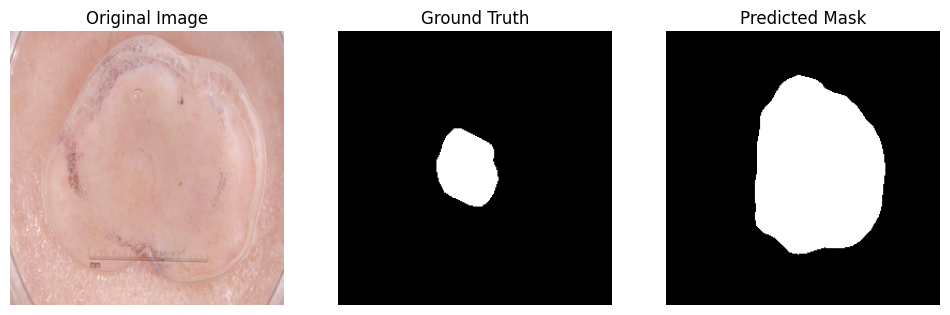

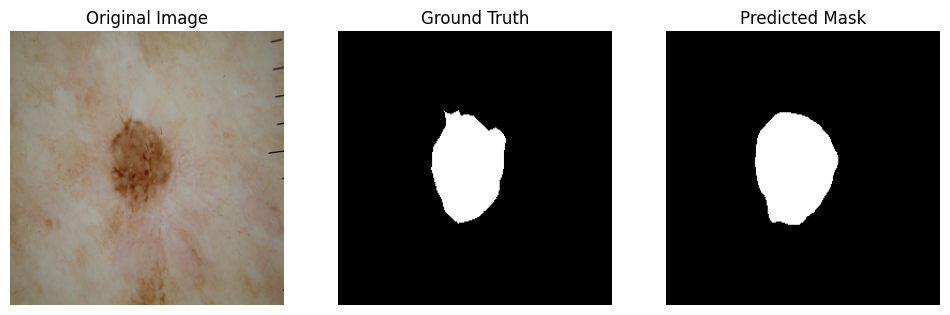

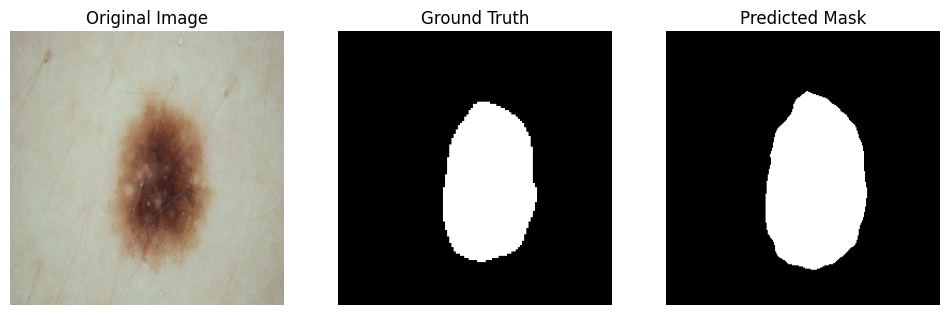

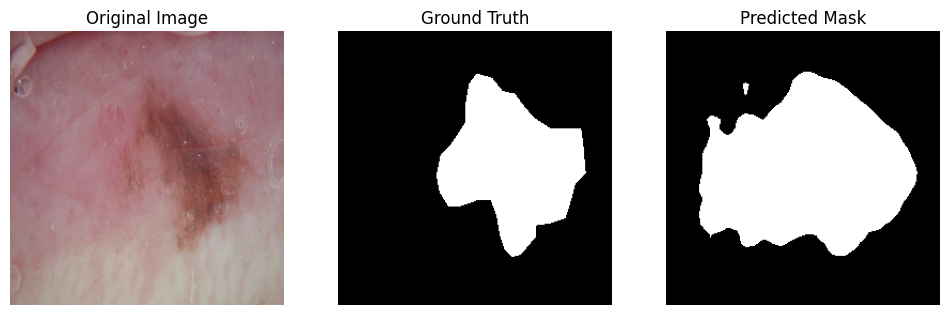

In [28]:
print("Teacher Model Predictions:")
display_predictions(teacher_model, val_loader, num_samples=5)

print("Student Model Predictions:")
display_predictions(student_model, val_loader, num_samples=5)
